### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

### Loading Data

In [4]:
# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

### Data Preprocessing

In [5]:
# Data preprocessing
# Merge datasets on Customer ID
combined = pd.merge(customers, transactions, on="CustomerID", how="inner")

# Handle missing or invalid data
combined.dropna(inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
combined['Region_Code'] = label_encoder.fit_transform(combined['Region'])

# Aggregate transaction data for each customer
aggregated = combined.groupby('CustomerID').agg({
    'Region': 'first',
    'Region_Code': 'first',
    'ProductID': 'count',  # Frequency of products
    'Price': 'mean'        # Average price
}).reset_index()

# Rename columns for clarity
aggregated.rename(columns={'ProductID': 'ProductFrequency', 'Price': 'AvgPrice'}, inplace=True)


### Normalization of Data

In [6]:
# Normalize numerical data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(aggregated[['Region_Code', 'ProductFrequency', 'AvgPrice']])

Clustering using K-Means

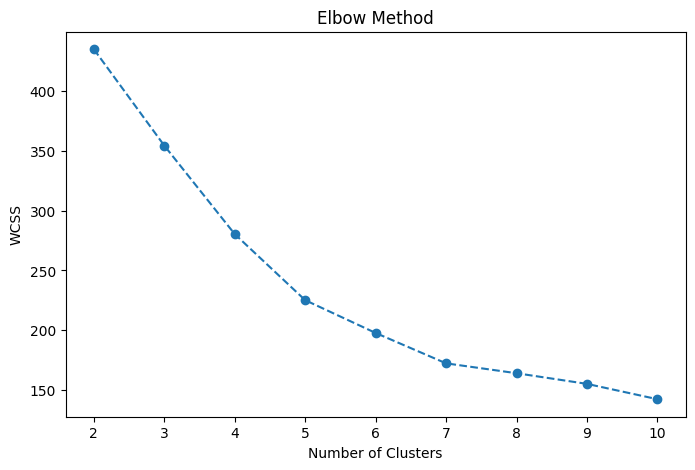

In [7]:
# Clustering
# Use the Elbow Method to find the optimal number of clusters
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(normalized_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Choose an optimal number of clusters (e.g., 4) based on the Elbow Method
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_data)

# Add cluster labels to the data
aggregated['Cluster'] = clusters


### Evaluation Metrices

In [8]:
# Evaluation Metrics
db_index = davies_bouldin_score(normalized_data, clusters)
silhouette_avg = silhouette_score(normalized_data, clusters)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


Davies-Bouldin Index: 1.115362186517632
Silhouette Score: 0.26672523790117947


### Visualization

2D Scatter plot

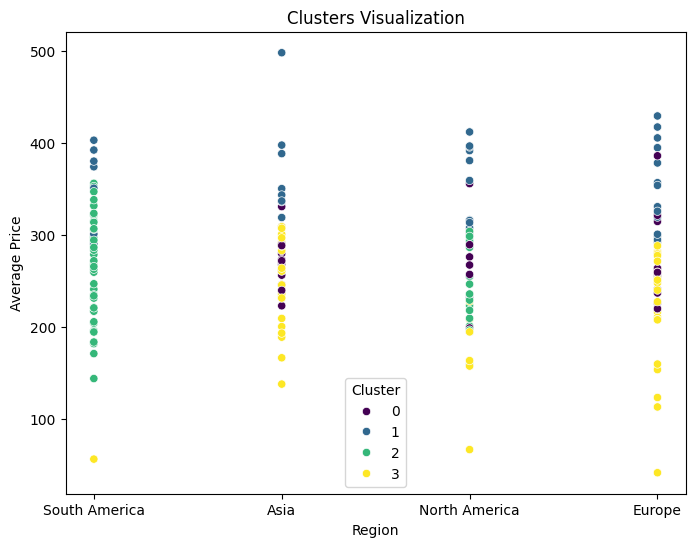

In [9]:
# 2D Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=aggregated['Region'], y=aggregated['AvgPrice'], hue=aggregated['Cluster'], palette='viridis')
plt.title('Clusters Visualization')
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.legend(title='Cluster')
plt.show()


3D Scatter plot

<ipython-input-10-fa0f8fa85439>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=cm.get_cmap('viridis', n_clusters),


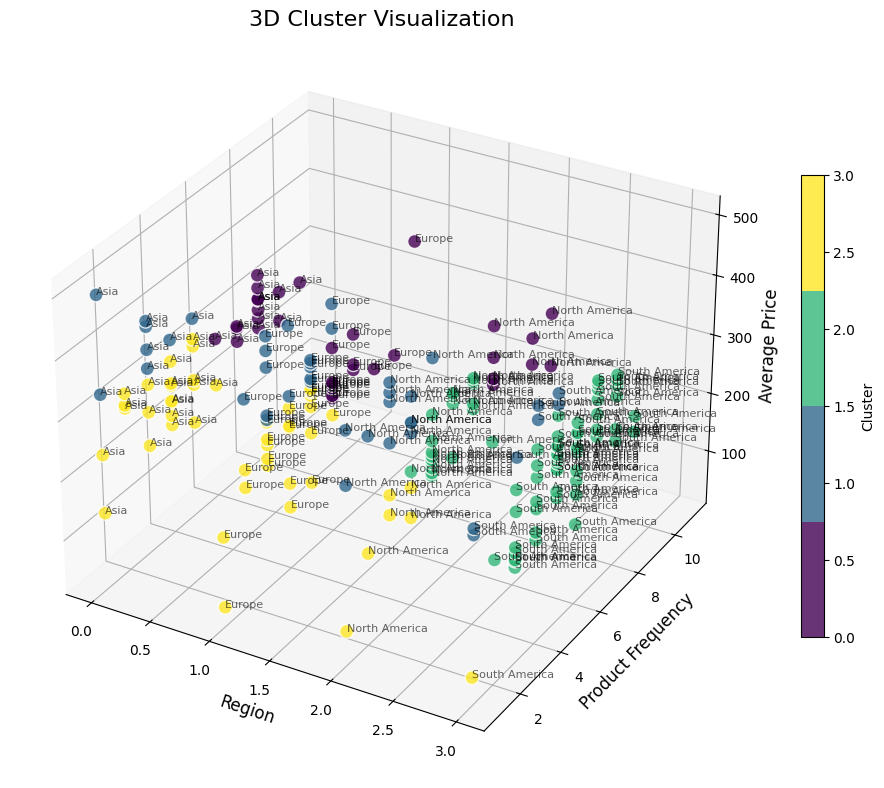

In [10]:
# 3D Scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a realistic view with better aesthetics
sc = ax.scatter(
    aggregated['Region_Code'],
    aggregated['ProductFrequency'],
    aggregated['AvgPrice'],
    c=aggregated['Cluster'],
    cmap=cm.get_cmap('viridis', n_clusters),
    s=100, alpha=0.8, edgecolors='w'
)

# Add region names back to the plot
region_labels = aggregated['Region']
for i, txt in enumerate(region_labels):
    ax.text(aggregated['Region_Code'].iloc[i],
            aggregated['ProductFrequency'].iloc[i],
            aggregated['AvgPrice'].iloc[i],
            txt, fontsize=8, alpha=0.6)

ax.set_title('3D Cluster Visualization', fontsize=16)
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Product Frequency', fontsize=12)
ax.set_zlabel('Average Price', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.colorbar(sc, ax=ax, label='Cluster', shrink=0.6)

# Add grid for better visualization
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Saving Result

In [11]:
# Save results
aggregated.to_csv('Vashist_Tiwari_Clustering.csv', index=False)